# TSF Internship task 7: Stock Hybrid model 

In this task, we are trying to predict stock prices. Stock prices are very uncertain and depend on a lot of factors. We are using two factor to predict it-one is the historical trend of that stock and another is the newsor whats happening in the world.
We are doing stock analysis of Americal Airlines Limited. 
This model will attempt to predict stock price using sentiments and historic prices. It will combine ARIMA and VADER models to create a hybrid model for that purpose. 

**Step 1: Setting the environment**

In this step the required packages will be downloaded and the datasets wil be loaded. 

In [132]:
# getting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import scipy.stats as stats
import pandas as pd
import seaborn as sb
sb.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller , acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14,6
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn.metrics import mean_squared_error  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [29]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sujoydutta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
pip install statsmodels==0.12.2

  Using cached statsmodels-0.12.2-cp39-none-win_amd64.whl (9.4 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 2.0.2 requires statsmodels>=0.13.2, but you have statsmodels 0.12.2 which is incompatible.


In [31]:

!pip install pandas-datareader

In [32]:
!pip install pmdarima

  Using cached statsmodels-0.13.5-cp39-cp39-win_amd64.whl (9.2 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [91]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sujoydutta\AppData\Roaming\nltk_data...


True

In [92]:

from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from collections import defaultdict
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [34]:
!pip install textblob

In [23]:
#getting the dataset
stockprices=pd.read_csv("C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Datasets\\Ensemble\\all_stocks_5yr.csv")
stockprices.head()

,S.no,date,open,high,low,close,volume,Name
0,1,08-02-13,15.07,15.12,14.63,14.75,8407500,AAL
1,2,11-02-13,14.89,15.01,14.26,14.46,8882000,AAL
2,3,12-02-13,14.45,14.51,14.10,14.27,8126000,AAL
3,4,13-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,5,14-02-13,14.94,14.96,13.16,13.99,31879900,AAL


In [80]:
#seeing null values
stockprices.isnull().sum()

S.no      0
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [25]:
#dropping null values
stockprices=stockprices.dropna()

In [26]:
#Seeing the time range
print(stockprices['date'].head())
print(stockprices['date'].tail())

0    08-02-13
1    11-02-13
2    12-02-13
3    13-02-13
4    14-02-13
Name: date, dtype: object
619035    01-02-18
619036    02-02-18
619037    05-02-18
619038    06-02-18
619039    07-02-18
Name: date, dtype: object


In [35]:
#formatting the date
stockprices['date'] = pd.to_datetime(stockprices['date'], format='%Y-%m-%d')
stockprices.info()

ValueError: time data 08-02-13 doesn't match format specified

In [36]:
#subsetting the dataset for better analysis
stocks=stockprices[0:6000]
stocks.head()

,S.no,date,open,high,low,close,volume,Name
0,1,08-02-13,15.07,15.12,14.63,14.75,8407500,AAL
1,2,11-02-13,14.89,15.01,14.26,14.46,8882000,AAL
2,3,12-02-13,14.45,14.51,14.10,14.27,8126000,AAL
3,4,13-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,5,14-02-13,14.94,14.96,13.16,13.99,31879900,AAL


**Step 2: preparing data set**

In this step we are building the time series model and studying how stock price changes with respect to time. Also we are preparing the dataset for further process. We will check if the time series is non stationery if it is non stationery we will make it stationery to study it better. 

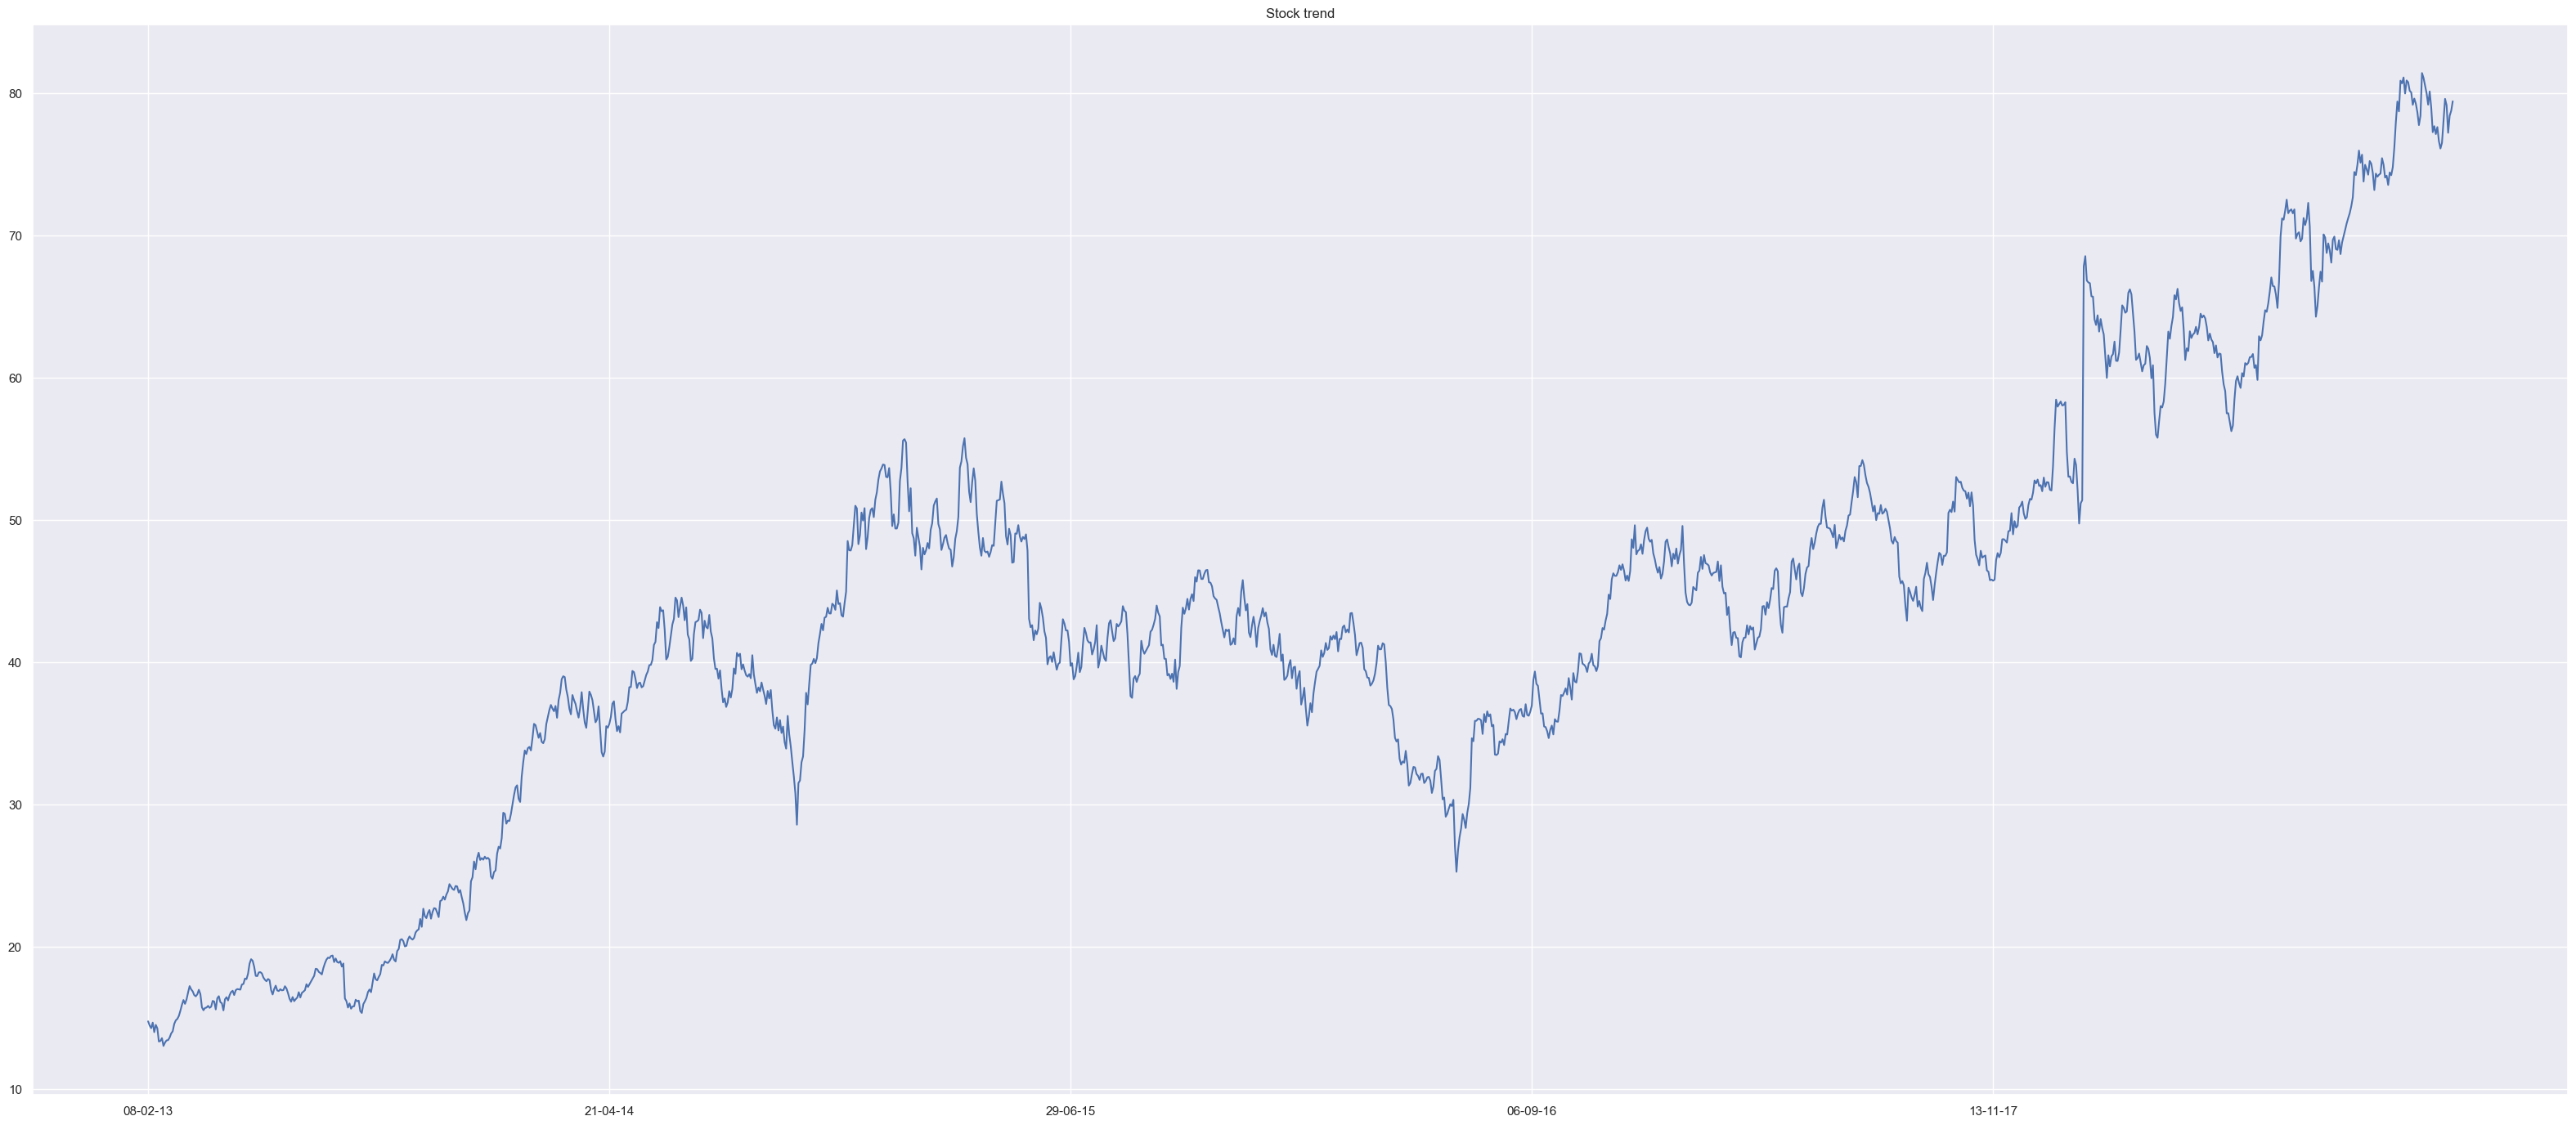

In [37]:
#plotting the trend of the stock prices
plt.figure(figsize=(40,17))
plt.title('Stock trend')
plt.plot(stocks['close'][0:1500])
plt.xticks(np.arange(0,1500, 300), stocks['date'][0:1500:300])
plt.show()

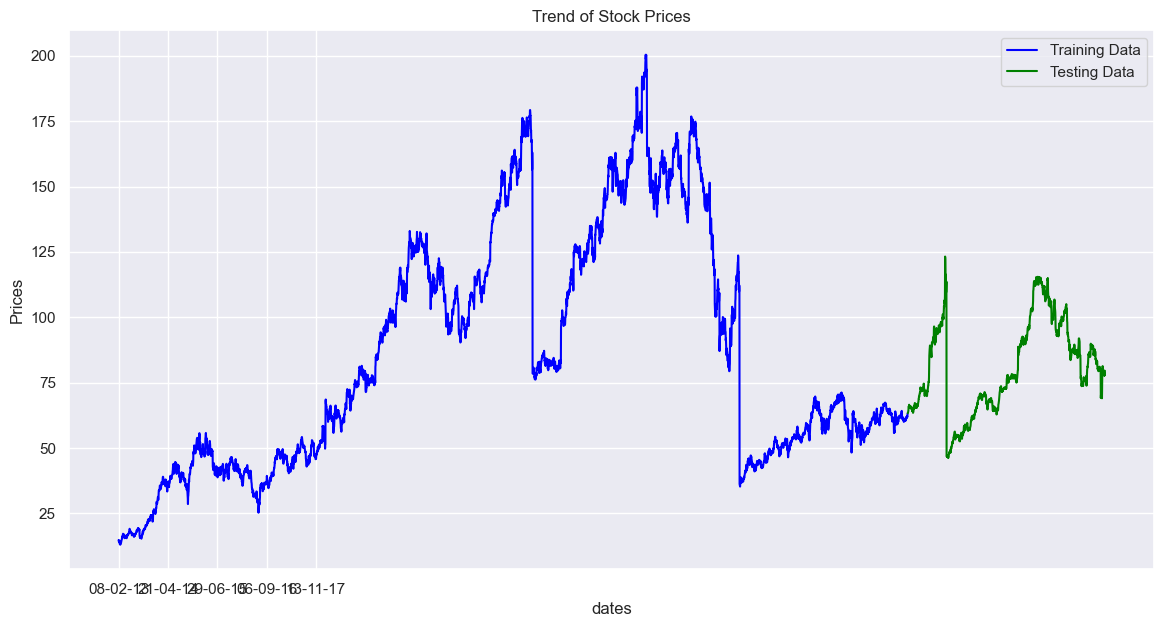

In [38]:
#determining training and testing part

train_data, test_data = stocks[0:int(len(stocks)*0.8)], stocks[int(len(stocks)*0.8):]
plt.figure(figsize=(14,7))
plt.title('Trend of Stock Prices')
plt.xlabel('dates')
plt.ylabel('Prices')
plt.plot(train_data['close'], 'blue', label='Training Data')
plt.plot(test_data['close'], 'green', label='Testing Data')
plt.xticks(np.arange(0,1500, 300), stocks['date'][0:1500:300])
plt.legend()

In [39]:
#testing stationarity 
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=52, center=False).mean()
    rolstd=timeseries.rolling(window=52, center=False).std()
    orig= plt.plot(timeseries, color='blue', label='Original')
    mean= plt.plot(rolmean, color='red', label='Rolling Mean')
    std= plt.plot(rolstd, color='green', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print('Results of D-F test')
    dftest= adfuller(timeseries, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test-Statistic','p-value','#Lags used',
                                           'Number of observations used'])

    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
    print(dfoutput)
    


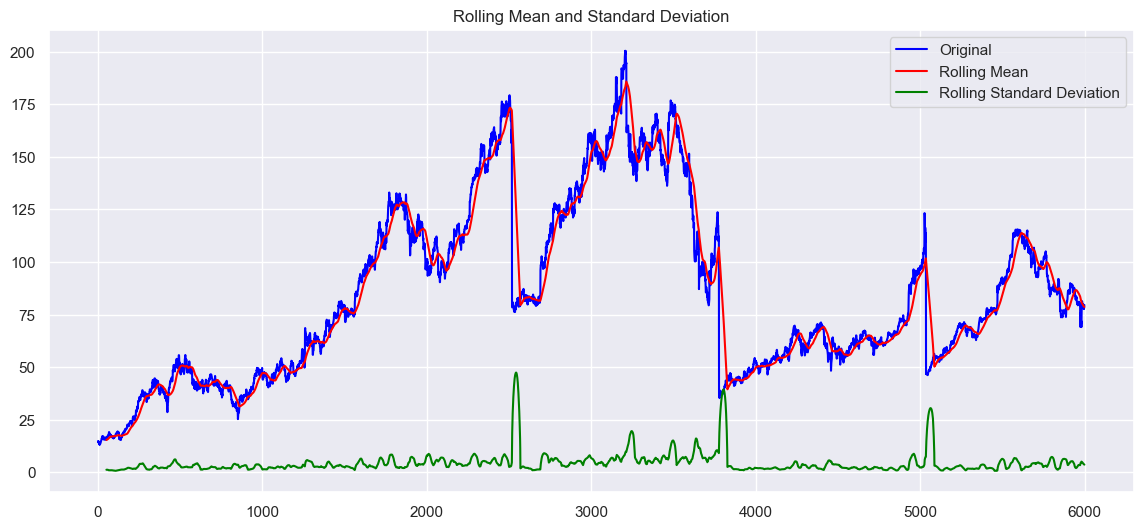

Results of D-F test
Test-Statistic                   -2.538467
p-value                           0.106393
#Lags used                        9.000000
Number of observations used    5990.000000
Critical value (1%)              -3.431442
Critical value (5%)              -2.862023
Critical value (10%)             -2.567027
dtype: float64


In [40]:
#seeing the graph
test_stationarity(stocks['close'])

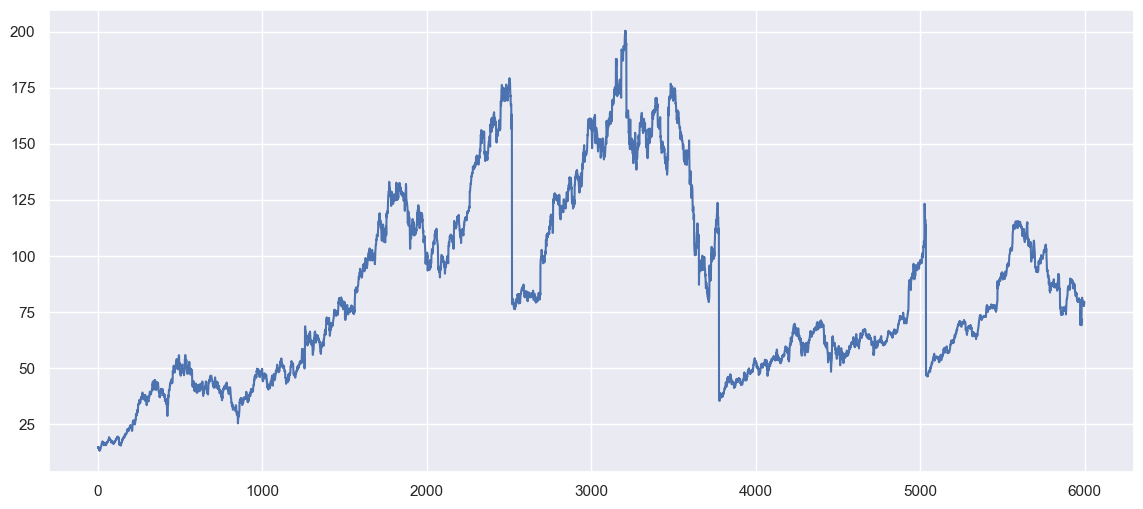

In [41]:
#applying logtransform
ts_log=np.log(stocks['close'])
#plotting timeseries
ts_log=stocks['close']
plt.plot(ts_log)

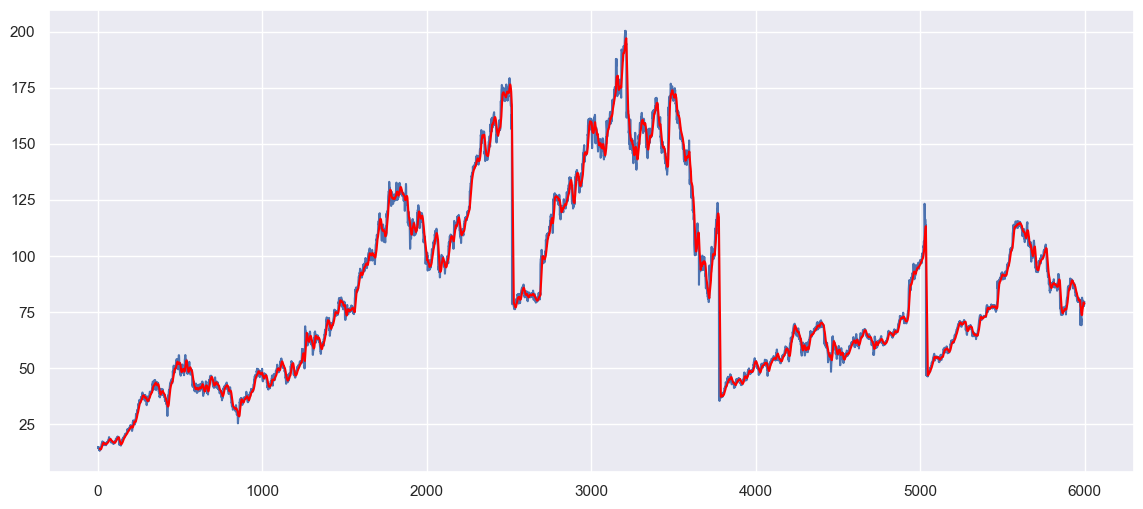

In [42]:
#plotting moving average
movingavg= ts_log.rolling(window=12).mean()
movingstd= ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingavg, color='red')

In [43]:
#seeing moving average
ts_log_mov_diff=ts_log- movingavg
print(ts_log_mov_diff.head(12))
ts_log_mov_diff.dropna(inplace=True)
print(ts_log_mov_diff.head(10))

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11   -0.693333
Name: close, dtype: float64
11   -0.693333
12   -0.431667
13   -0.325833
14   -0.090833
15    0.262500
16    0.407500
17    0.921667
18    1.125000
19    1.092500
20    1.155833
Name: close, dtype: float64


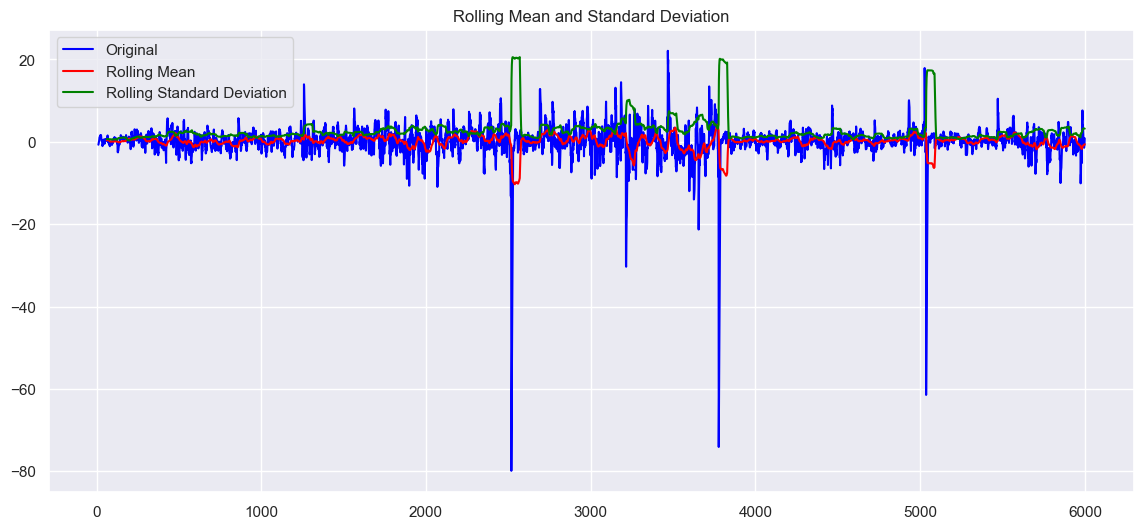

Results of D-F test
Test-Statistic                -1.699186e+01
p-value                        8.857037e-30
#Lags used                     1.200000e+01
Number of observations used    5.976000e+03
Critical value (1%)           -3.431445e+00
Critical value (5%)           -2.862024e+00
Critical value (10%)          -2.567028e+00
dtype: float64


In [44]:
#checking of log transformed
test_stationarity(ts_log_mov_diff)

**Finding**

The Test-Statistic is -1.7 which is less than the 1% critical value which means we are 99% sure that the series is a stationery series. It means that the average and variance of the time series is constant and the covariance doesnt depend on time.It was non stationary in the beginning and we used decompostion method to make the model stationery.

**Step 3: Building ARIMA**

In this step we will build the ARIMA model which is Auto Regressive Integrated Moving Average which forecasts future values based on past values. 

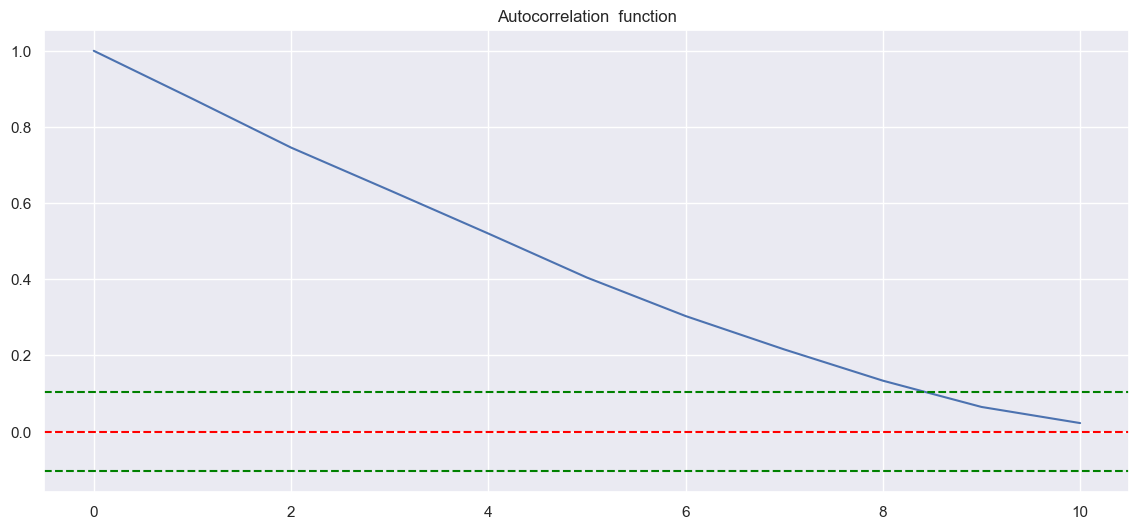

In [45]:
#plotting the acf
plt.plot(np.arange(0,11), acf(ts_log_mov_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--', color='green')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--', color='green')
plt.title('Autocorrelation  function')
plt.show()

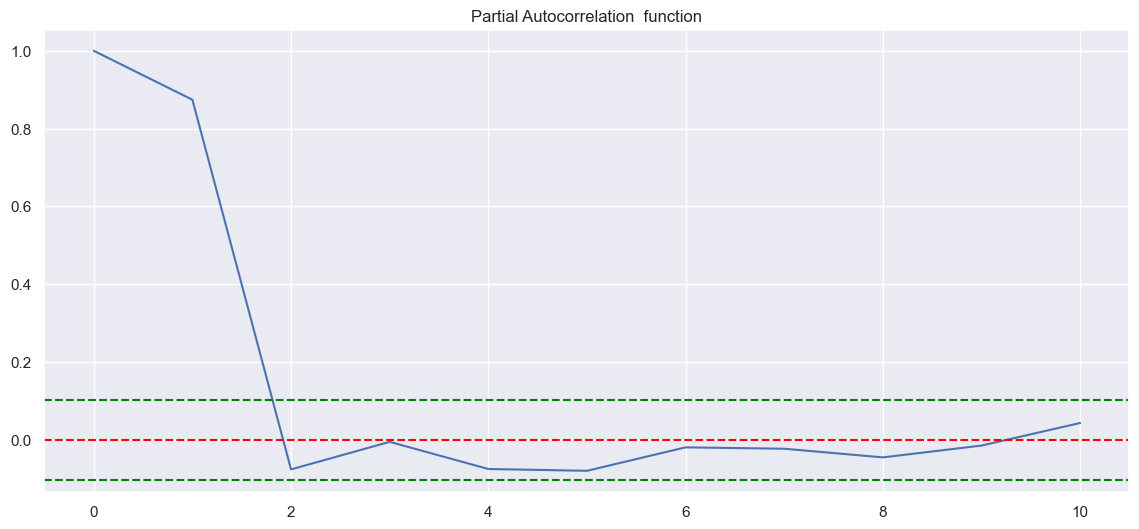

In [46]:
#plotting the pacf
plt.plot(np.arange(0,11), pacf(ts_log_mov_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--', color='green')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--', color='green')
plt.title('Partial Autocorrelation  function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

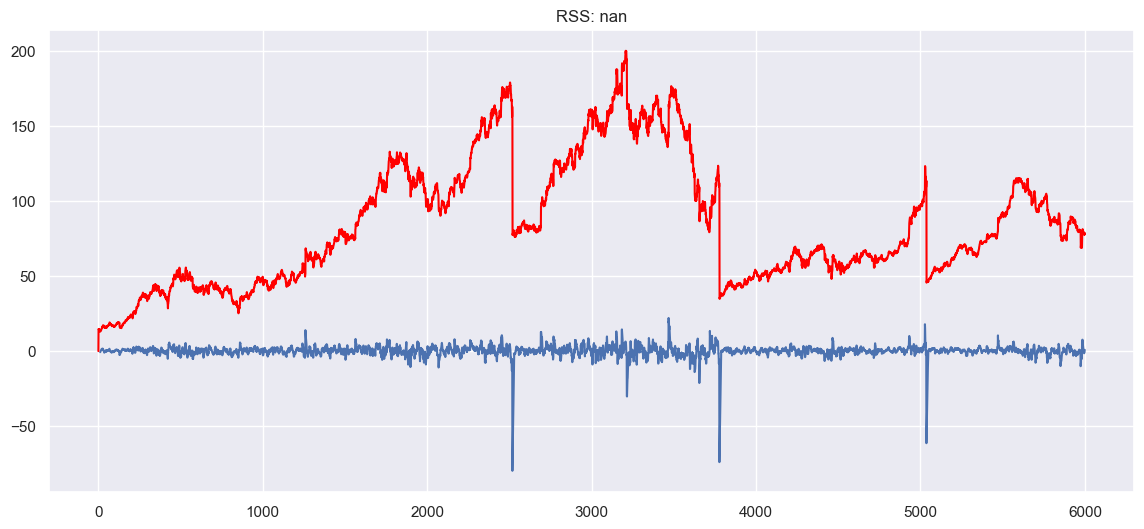

In [47]:
#fitted values
model = ARIMA(ts_log, order=(1,1,0))
results_ARIMA = model.fit()
plt.plot(ts_log_mov_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mov_diff)**2))

In [48]:
#seeing predicted values
predictions_ARIMA_diff= pd.Series(results_ARIMA.fittedvalues, copy= True)
predictions_ARIMA_diff.head().round()

0     0.0
1    15.0
2    14.0
3    14.0
4    15.0
dtype: float64

In [49]:
#determining cumulative sum
predictions_ARIMA_diff_cmsm= predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cmsm.tail().round()

5995    506390.0
5996    506467.0
5997    506545.0
5998    506623.0
5999    506702.0
dtype: float64

In [50]:
#adding cumulative sum to the base number
predictions_ARIMA_log= pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log= predictions_ARIMA_log.add(predictions_ARIMA_diff_cmsm, fill_value=0)
predictions_ARIMA_log.head().round()

0    15.0
1    30.0
2    44.0
3    58.0
4    73.0
dtype: float64

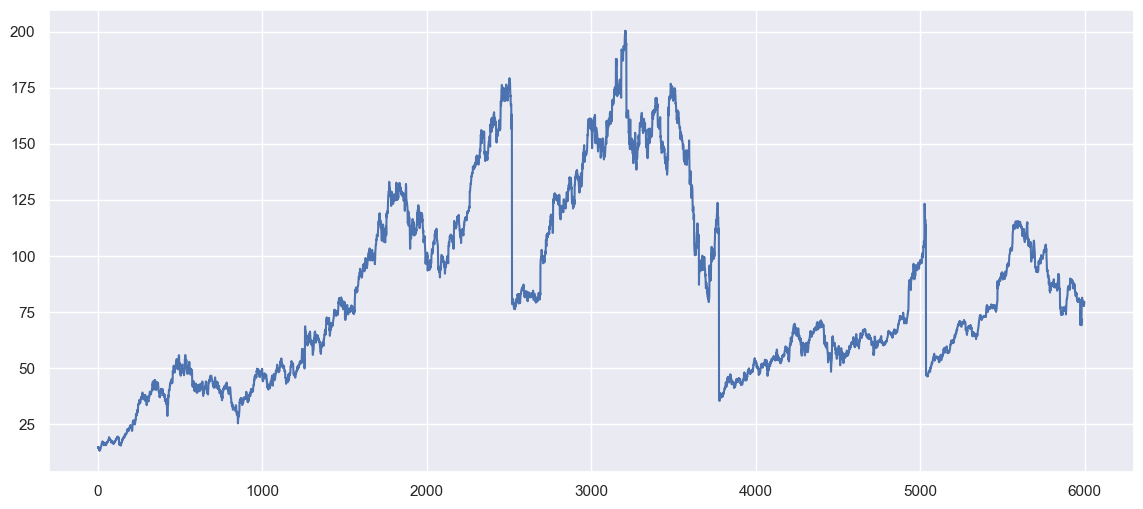

In [51]:
#seeing the closing price trends

ts=stocks['close']
plt.plot(ts)

In [52]:
#smape function to evaluare
def smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [53]:
#partitioning the data into train and test
train_ar = train_data['close'][0:800].values
test_ar = test_data['close'][800:1000].values
  

In [54]:
#building the model
history = [x for x in train_ar]
print(type(history))

predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
output = model_fit.forecast()


<class 'list'>


**Step 4:Testing the model**

In this step we are going to check errors and see accuracy of the model we built. Also we will plot the values to see the efficacy of the model.

In [61]:
#seeing the error
yhat = output[0]
predictions.append(yhat)
obs = test_ar[t]
history.append(obs) 
error = mean_squared_error(test_ar[0:2], predictions[0:2])
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape(test_ar[0:2], predictions[0:2])
print('Symmetric mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 5579.995
Symmetric mean absolute percentage error: 96.585


In [62]:
#seeing the model stats
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1013.330
Date:                Mon, 20 Feb 2023   AIC                           2030.661
Time:                        10:49:59   BIC                           2040.027
Sample:                             0   HQIC                          2034.259
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0642      0.031      2.079      0.038       0.004       0.125
sigma2         0.7398      0.025     29.979      0.000       0.691       0.788
Ljung-Box (L1) (Q):                   0.01   Jarque-

<AxesSubplot: >

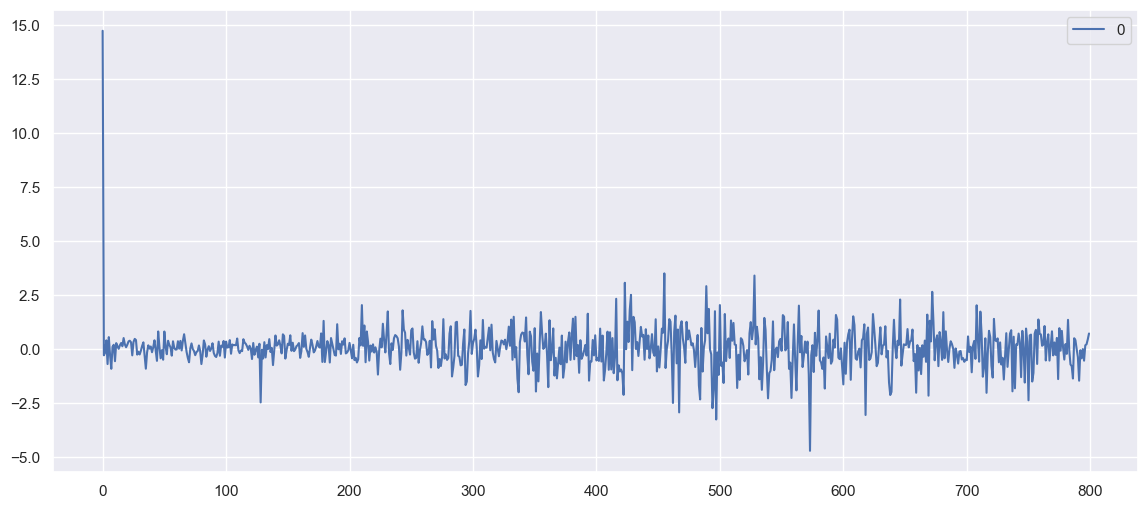

In [63]:
#seeing the residuals
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()

In [64]:
stocks

,S.no,date,open,high,low,close,volume,Name
0,1,08-02-13,15.07,15.12,14.63,14.75,8407500,AAL
1,2,11-02-13,14.89,15.01,14.26,14.46,8882000,AAL
2,3,12-02-13,14.45,14.51,14.10,14.27,8126000,AAL
3,4,13-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,5,14-02-13,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...,...
5995,5996,29-11-16,78.65,79.36,77.53,77.63,2493695,ABC
5996,5997,30-11-16,77.72,78.92,77.45,77.99,5158879,ABC
5997,5998,01-12-16,77.88,78.70,77.61,77.80,1505641,ABC
5998,5999,02-12-16,78.15,79.58,77.66,78.80,1733280,ABC


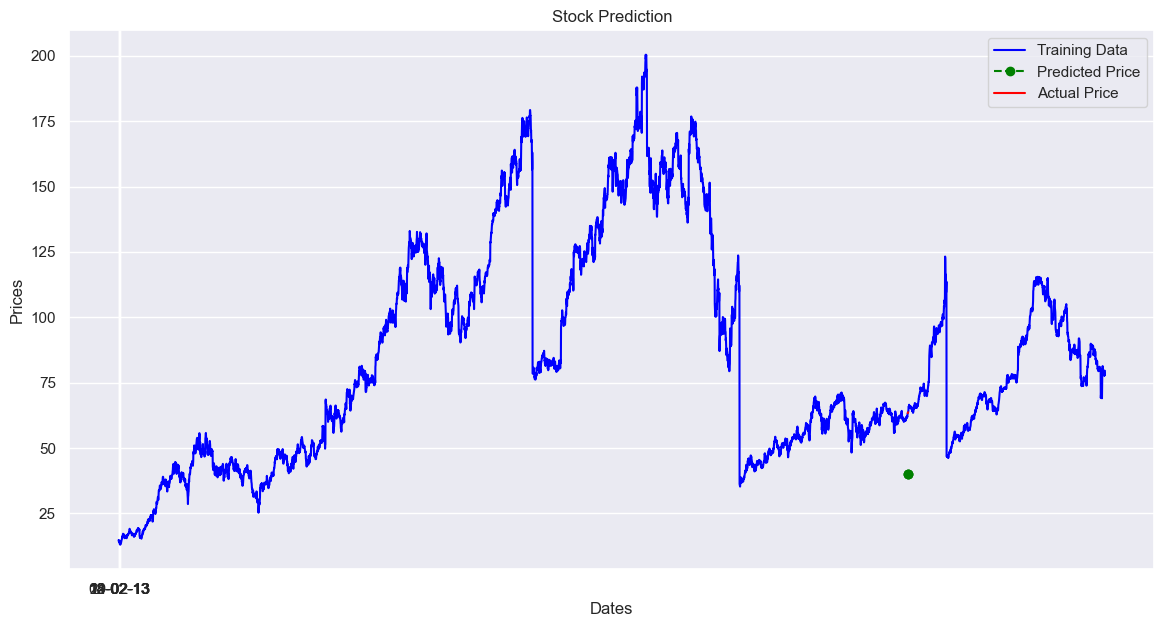

In [69]:
#making the predictions
plt.figure(figsize=(14,7))
plt.plot(stocks['close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index[0:3], predictions[0:3], color='green', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data.index[0:3], test_data['close'][0:3], color='red', label='Actual Price')
plt.title('Stock Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,10, 2), stocks['date'][0:10:2])
plt.legend()

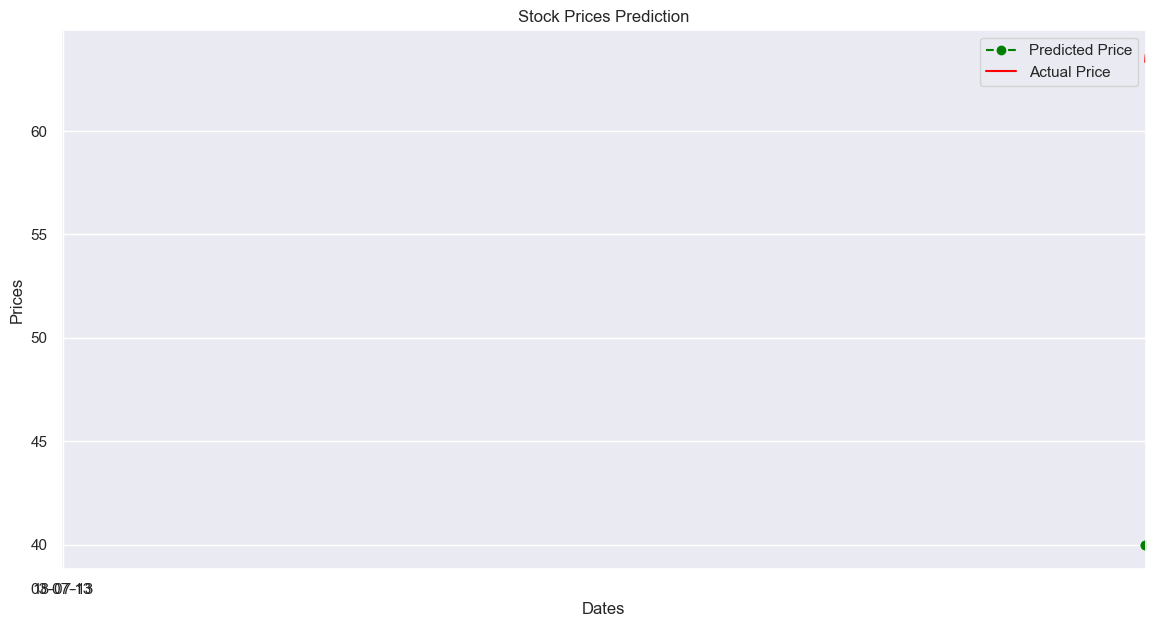

In [67]:
#actual vs predicted plot
plt.figure(figsize=(14,7))
plt.plot(test_data.index[0:3], predictions[0:3],  color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index[0:3], test_data['close'][0:3], color='red', label='Actual Price')
plt.legend()
plt.title('Stock Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(100,120,10), stocks['date'][100:120:10])
plt.legend()

**Conclusion**

The model is not very good at predicting the stock prices based on existing data and it shows in the graph. There is a lot of difference between the actual and the predicted price. 


**Step 5: Sentimental analysis**

In this part we are going to use VADER (Valence Aware Dictionary and Sentiment Reasoner) to do the sentiment analysis of the news.


In [70]:
#getting the dataset
news=pd.read_csv("C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Datasets\\Ensemble\\\india-news-headlines.csv")
news.head()

,S.no,publish_date,headline_category,headline_text
0,1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2,20010102,unknown,Fissures in Hurriyat over Pak visit
2,3,20010102,unknown,America's unwanted heading for India?
3,4,20010102,unknown,For bigwigs; it is destination Goa
4,5,20010102,unknown,Extra buses to clear tourist traffic


In [71]:
#seeing null values
news.isnull().any()

S.no                 False
publish_date         False
headline_category    False
headline_text        False
dtype: bool

In [72]:
#seeing value counts of headlines
news['headline_text'].value_counts()

Straight Answers                                   6723
Straight answers                                   1500
Day in Pics                                         756
Cartoons                                            547
Photogallery                                        326
                                                   ... 
Kidnapped schoolboy rescued; 12 held                  1
Nitish Kumar to be CM if NDA comes to power           1
Scientists succeed in containing sugarcane pest       1
IT raids at Vicco Lab's offices                       1
Police to peon: Crowd control a joint venture         1
Name: headline_text, Length: 965132, dtype: int64

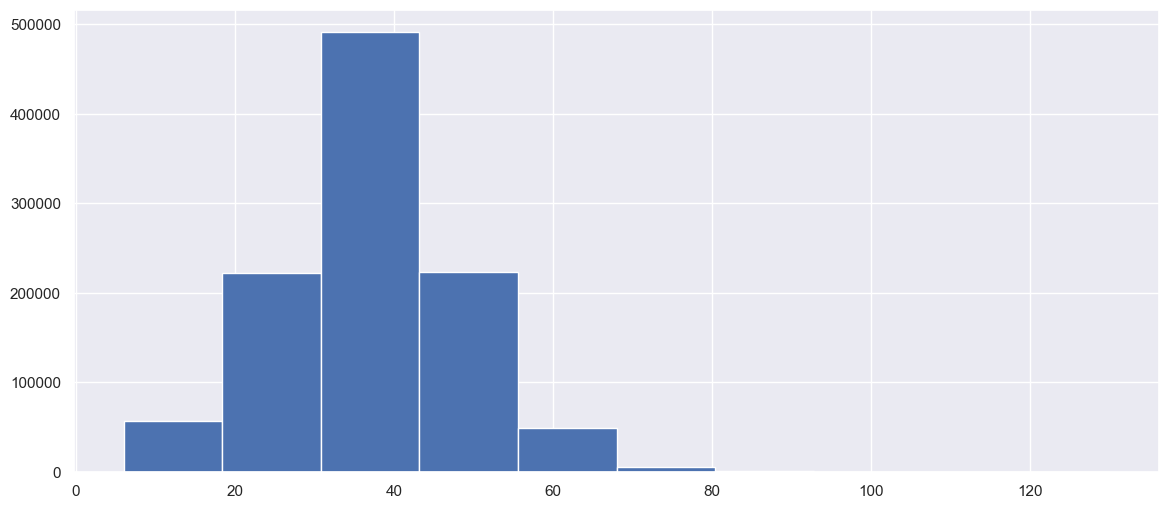

In [73]:
#seeing length of headlines
news['headline_text'].str.len().hist()
plt.show()

In [74]:
#creating a collection of stopwords
stopwords = []
new = news['headline_text'].str.split()
new = new.values.tolist()
stopwords = [word for i in new for word in i]
dict = defaultdict(int)
for word in stopwords:
    if word in stop:
        dict[word]+=1
 

In [75]:


#counting stopwords
counter = Counter(stopwords)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)       

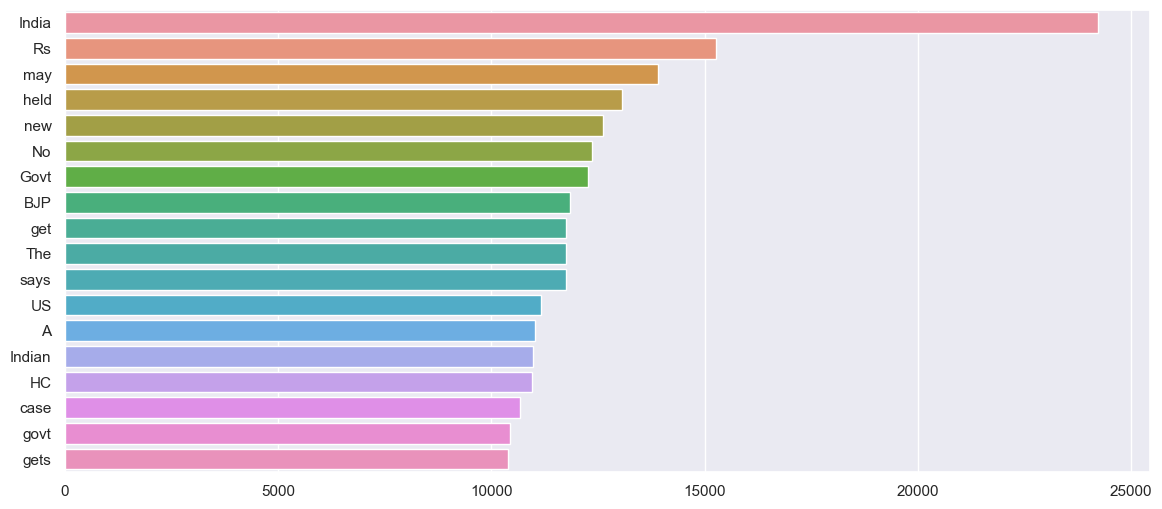

In [81]:
#plotting popular stopwords
sb.barplot(x = y , y = x)
plt.show()

In [98]:
#subsetting news dataset for simplicity
newss=news[0:6000]
print(len(news))
print(len(newss))

1048575
6000


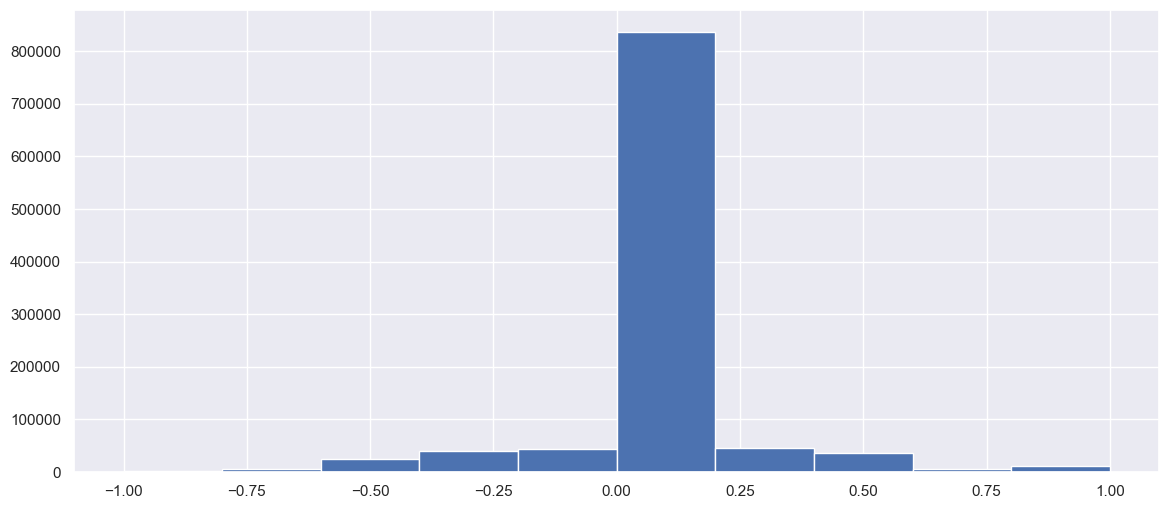

In [99]:
#making polarity function
def polarity(text):
    return TextBlob(text).sentiment.polarity
newss['polarity_score'] = newss['headline_text'].\
   apply(lambda x : polarity(x))
news['polarity_score'].hist()
plt.show()

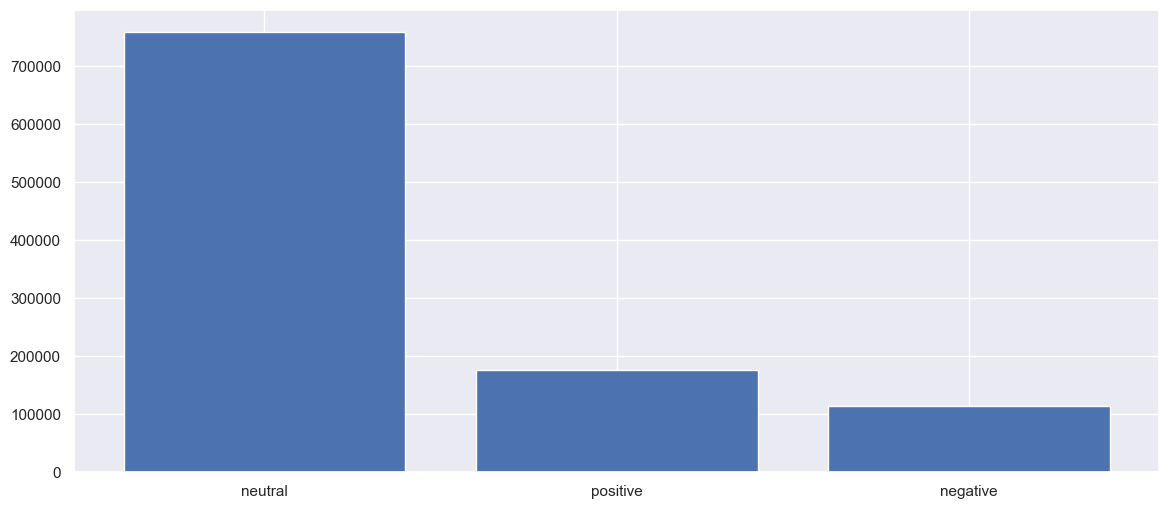

In [100]:
#making sentiments function
def sentiment(x):
    if x < 0:
        return 'negative'
    elif x == 0:
        return 'neutral'
    else:
        return 'positive'
    
newss['polarity'] = newss['polarity_score'].\
   map(lambda x : sentiment(x))
plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())
plt.show()

In [93]:
#initializing sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [108]:
#making a new dataset with sentiments and polarity

newss['Negative'] = [sia.polarity_scores(v)['neg'] for v in newss['headline_text']]
newss['Neutral'] = [sia.polarity_scores(v)['neu'] for v in newss['headline_text']]
newss['Positive'] = [sia.polarity_scores(v)['pos'] for v in newss['headline_text']]
newss[0:5]


,S.no,publish_date,headline_category,headline_text,polarity_score,polarity,Negative,Neutral,Positive
0,1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,0.00,neutral,0.000,0.805,0.195
1,2,20010102,unknown,Fissures in Hurriyat over Pak visit,0.00,neutral,0.000,1.000,0.000
2,3,20010102,unknown,America's unwanted heading for India?,0.00,neutral,0.322,0.678,0.000
3,4,20010102,unknown,For bigwigs; it is destination Goa,0.00,neutral,0.000,1.000,0.000
4,5,20010102,unknown,Extra buses to clear tourist traffic,0.05,positive,0.000,0.658,0.342


**Step 6: Building Final model**

In this step the previous models will be combined to create a final model. The models will be joined first and then we will use another algorithm to make predictions.


In [109]:
final = pd.merge(stocks, newss, how='inner', on='S.no')
final.head()

,S.no,date,open,high,low,close,volume,Name,publish_date,headline_category,headline_text,polarity_score,polarity,Negative,Neutral,Positive
0,1,08-02-13,15.07,15.12,14.63,14.75,8407500,AAL,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...,0.00,neutral,0.000,0.805,0.195
1,2,11-02-13,14.89,15.01,14.26,14.46,8882000,AAL,20010102,unknown,Fissures in Hurriyat over Pak visit,0.00,neutral,0.000,1.000,0.000
2,3,12-02-13,14.45,14.51,14.10,14.27,8126000,AAL,20010102,unknown,America's unwanted heading for India?,0.00,neutral,0.322,0.678,0.000
3,4,13-02-13,14.30,14.94,14.25,14.66,10259500,AAL,20010102,unknown,For bigwigs; it is destination Goa,0.00,neutral,0.000,1.000,0.000
4,5,14-02-13,14.94,14.96,13.16,13.99,31879900,AAL,20010102,unknown,Extra buses to clear tourist traffic,0.05,positive,0.000,0.658,0.342


In [119]:
#taking only necessary columns

finaldf = final[['close','polarity_score','Negative','Neutral','Positive']]
finaldf

,close,polarity_score,Negative,Neutral,Positive
0,14.75,0.00,0.000,0.805,0.195
1,14.46,0.00,0.000,1.000,0.000
2,14.27,0.00,0.322,0.678,0.000
3,14.66,0.00,0.000,1.000,0.000
4,13.99,0.05,0.000,0.658,0.342
...,...,...,...,...,...
5995,77.63,0.00,0.000,0.652,0.348
5996,77.99,-0.50,0.000,1.000,0.000
5997,77.80,0.00,0.000,1.000,0.000
5998,78.80,0.00,0.439,0.561,0.000


In [121]:
#initializing scaler to scale the variables
sc = MinMaxScaler()

In [122]:
#scaling the variables
finalsc = pd.DataFrame(sc.fit_transform(finaldf))
finalsc .columns = finaldf.columns
finalsc .index = finaldf.index
finalsc .head()

,close,polarity_score,Negative,Neutral,Positive
0,0.009234,0.500,0.000,0.805,0.195
1,0.007686,0.500,0.000,1.000,0.000
2,0.006672,0.500,0.322,0.678,0.000
3,0.008753,0.500,0.000,1.000,0.000
4,0.005177,0.525,0.000,0.658,0.342


In [125]:
#separating X and y
X=finalsc.drop("close",axis=1)
y=finalsc["close"]

In [127]:
#splitting the dataset into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=40)

In [128]:
# making random forest regressor and fitting
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [129]:
# Making the predictions

y_pred_rf=rf.predict(X_test)

y_pred_rf

array([0.19544576, 0.38477056, 0.38477056, ..., 0.39571033, 0.38477056,
       0.27189   ])

In [134]:
#seeing fitness metrics of the model made
mse_rf = metrics.mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2 = r2_score(y_test,y_pred_rf)
r2
print("The R squared scored of the model is:",r2)
print("Random Forest Model RMSE: ",rmse_rf)

The R squared scored of the model is: -0.05531038976916647
Random Forest Model RMSE:  0.22883925973351654


**Conclusion**

The R squared of the model is returning a negative value which means the model made is not very effective and hence unusable. It implies that the news and stock values are totally unrelated. 